In [1]:
import ollama
import glob
from PIL import Image
import json
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt

from utils.ChairScorer import ChairScorer

In [2]:
PROMPTS = ["Make a caption describing the image."]
RESPONSES_PER_IMAGE = 1
IMG_TEST_PATH = "../data/coco/val2017/000000179765.jpg"
IMG_TEST_ID=int(Path(IMG_TEST_PATH).stem)

# CHAIR
PATH_INSTANCES = "../data/coco/annotations/instances_val2017.json"
PATH_SYNONYMS = "utils/our_data/coco_synonyms_SOTA.txt"

## UTILS

Load captions for each picture.

In [3]:
CAPTIONS_MAP_PATH = "utils\our_data\captions_map.pkl"

if not os.path.exists(CAPTIONS_MAP_PATH):
    print("Fichier introuvable.")
else:
    with open(CAPTIONS_MAP_PATH, "rb") as f:
        coco_captions = pickle.load(f)
        print(f"ground truth captions loaded : {len(coco_captions)}")

ground truth captions loaded : 5000


# Model

In [4]:
all_images = glob.glob("../data/coco/val2017/*.jpg")

images_to_process = [IMG_TEST_PATH]

# Récupère les ids des images dans l'ordre de images_to_process
images_ids = [int(Path(path).stem) for path in images_to_process]

print(f"--- Starting analysis. Selected images : {len(images_to_process)}/{len(all_images)} ---")
print(f"Number of responses per images : {RESPONSES_PER_IMAGE}")
print(f"Prompts : {PROMPTS}")

# Dict of model responses per image (key = image id, value = list of responses)
model_responses = {}

for n,img_path in enumerate(images_to_process):
    img_id = images_ids[n]

    print(f"Analyse de : {img_id}, {img_path}")
    
    for _ in range(RESPONSES_PER_IMAGE):

      try:
         reponse = ollama.chat(
               model='llava',
               messages=[{
                  'role': 'user',
                  'content': PROMPTS[0],
                  'images': [img_path]
               }]
         )
         
         description = reponse['message']['content']
         description = description.strip().strip('"')
         print(description)

         if img_id not in model_responses:
               model_responses[img_id] = []
         model_responses[img_id].append(description) 

      except Exception as e:
        print(f"Erreur sur l'image {img_path}: {e}")   

# We create a dictionnary of ground truth captions for the specific images tested below
gt_captions_dict = {img_id: coco_captions.get(img_id, "Pas de légende trouvée") for img_id in model_responses}


--- Starting analysis. Selected images : 1/5000 ---
Number of responses per images : 1
Prompts : ['Make a caption describing the image.']
Analyse de : 179765, ../data/coco/val2017/000000179765.jpg
A vintage motorcycle parked in the yard, ready for an adventure on two wheels.


Demo image test

Model captions : 
A vintage motorcycle parked in the yard, ready for an adventure on two wheels.


Ground truth captions : 
A black Honda motorcycle parked in front of a garage.
A Honda motorcycle parked in a grass driveway
A black Honda motorcycle with a dark burgundy seat.
Ma motorcycle parked on the gravel in front of a garage
A motorcycle with its brake extended standing outside


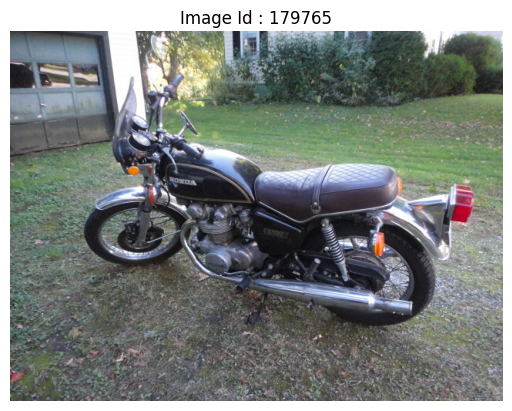

In [5]:
print(f"Model captions : ")
for str in model_responses[IMG_TEST_ID]:
   print(f"{str}")
print("\n")

print(f"Ground truth captions : ")
for str in gt_captions_dict[IMG_TEST_ID]:
   print(f"{str}")

img = Image.open(IMG_TEST_PATH)
plt.imshow(img)
plt.axis('off') # Pour cacher les axes X et Y
plt.title(f"Image Id : {IMG_TEST_ID}")
plt.show()

# METRIQUES

In [ ]:
import string
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

class Scorer:
    def __init__(self, numberOfResponses=RESPONSES_PER_IMAGE, chairParameters=(PATH_INSTANCES,PATH_SYNONYMS)):
        self.numberOfResponses = numberOfResponses
        self.path_instances, self.path_synonyms = chairParameters

    def sanitize_text(self, text):
      text = text.lower()
      text = text.replace('\n', ' ').replace('\r', ' ') 
      text = text.translate(str.maketrans('', '', string.punctuation))
      text = " ".join(text.split())
      return text

    def sanitize_dict(self, data_dict):
        """
        Applique le nettoyage sur tout un dictionnaire {id: [liste_captions]}
        """
        clean_dict = {}
        for img_id, captions in data_dict.items():
            clean_dict[img_id] = [self.sanitize_text(c) for c in captions]
        return clean_dict

    def compute_bleu(self, gts, res):
        """
        BLEU (Bilingual Evaluation Understudy)
        Compte le nombre de séquences de mots (n-grammes) qui apparaissent à la fois dans la légende générée et dans la référence. 
        Mesure de précision. Peu fiable car ne reconnaît pas les synonymes.

        PARAMETERS : 

         gts: Dictionnaire {image_id: [liste_de_captions_reference]}
         res: Dictionnaire {image_id: [liste_de_captions_generees]}
        """
        print(f"Calcul de Bleu...")

        gts = self.sanitize_dict(gts)
        res = self.sanitize_dict(res)

        eval_result = {}

        scorer, methods = (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"])
        
        # global score, individual scores 
        score, _ = scorer.compute_score(gts,res)

        for m, s in zip(methods,score):
            eval_result[m] = s

        return eval_result
    
    # TODO Bibliothèque galère à utiliser sur windows à cause des passage en java (à tester avec JAVA 8)
    def compute_meteor(self,gts,res):
        """
        METEOR (Metric for Evaluation of Translation with Explicit ORdering)
        Similaire à BLEU. Aligne les mots en utilisant non seulement la correspondance exacte,
        mais aussi les synonymes (via WordNet) et les racines des mots (stemming).
        Permet de mesurer la richesse du vocabulaire.

        PARAMETERS : 

         gts: Dictionnaire {image_id: [liste_de_captions_reference]}
         res: Dictionnaire {image_id: [liste_de_captions_generees]}
        """
        return None
    
    def compute_cider(self,gts,res):
        """
        CIDEr (Consensus-based Image Description Evaluation)
        Utilise une approche TF-IDF pour donner plus de poids aux mots importants et moins aux mots courants. 
        Elle mesure à quel point la légende générée capture le "consensus" des références humaines.
        Métrique standard dans les compétitions de captioning (comme COCO)

        PARAMETERS : 

         gts: Dictionnaire {image_id: [liste_de_captions_reference]}
         res: Dictionnaire {image_id: [liste_de_captions_generees]}
        """
        print(f"Calcul de CIDEr...")

        gts = self.sanitize_dict(gts)
        res = self.sanitize_dict(res)

        scorer = Cider()

        score, _ = scorer.compute_score(gts,res)

        return score
    
    def compute_spice(self, gts, res):
        """
        SPICE (Semantic Propositional Image Caption Evaluation)
        transforme les captions (ground truth et response) en "graphes de scène" et compare ensuite ces graphes.
        Exemple : elle vérifie si le modèle a bien détecté (Chat) -> [est sur] -> (Tapis).
        """
        print(f"Calcul de SPICE...")
    
        try:
         spice_scorer = Spice()
        except Exception as e:
         print(f"Erreur à l'init de SPICE (Java manquant ?): {e}")
         return None

        gts = self.sanitize_dict(gts)
        res = self.sanitize_dict(res)

        avg_score, scores_detailed = spice_scorer.compute_score(gts, res)
        return avg_score, scores_detailed
        
    
    def compute_chair(self,res):
        """
        CHAIR (Caption Hallucination Assessment with Image Relevance)
        C'est une métrique spécialisée pour détecter les hallucinations. 
        Elle calcule le pourcentage d'objets mentionnés dans la légende qui ne sont pas présents dans l'image 
        (basé sur la liste d'objets connus par exemple grace une segmentation).
        """
        print(f"Calcul de CHAIR...")

        res = self.sanitize_dict(res)
        
        scorer = ChairScorer(self.path_instances,self.path_synonyms)
        score = scorer.compute_score(res)
        return score
    
    def compute_scores(self,gts,res):
        eval_result = {}

        if (self.numberOfResponses==1):
            # CIDEr
            eval_result["CIDEr"] = self.compute_cider(gts,res)

            # BLEU
            bleu_result = self.compute_bleu(gts,res)
            eval_result = eval_result | bleu_result

            # SPICE
            avg_spice,_ = self.compute_spice(gts,res)
            eval_result["SPICE"] = avg_spice

            # CHAIR
            eval_result["CHAIR"] = self.compute_chair(res)

        return eval_result



In [7]:
print(gt_captions_dict)
print(model_responses)

scorer = Scorer()

results = scorer.compute_scores(gt_captions_dict, model_responses)

print("\n--- Résultats Finaux ---")
for metric, score in results.items():
   print(f"{metric}: {score:.4f}")

{179765: ['A black Honda motorcycle parked in front of a garage.', 'A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle with a dark burgundy seat.', 'Ma motorcycle parked on the gravel in front of a garage', 'A motorcycle with its brake extended standing outside']}
{179765: ['A vintage motorcycle parked in the yard, ready for an adventure on two wheels.']}
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 14, 'reflen': 11, 'guess': [14, 13, 12, 11], 'correct': [6, 2, 1, 0]}
ratio: 1.2727272726115704
Calcul de SPICE...
Nettoyage des données...
Calcul de CHAIR...
Chargement des annotations GT depuis ../data/coco/annotations/instances_val2017.json...

--- Résultats Finaux ---
CIDEr: 0.0000
Bleu_1: 0.4286
Bleu_2: 0.2568
Bleu_3: 0.1765
Bleu_4: 0.0000
SPICE: 0.0588
CHAIR: 0.0000


In [9]:
scorer = ChairScorer(PATH_INSTANCES, PATH_SYNONYMS)
scorer.test(model_responses)

Chargement des annotations GT depuis ../data/coco/annotations/instances_val2017.json...
GROUND TRUTH objects in image : {'motorcycle'}
RESPONSE objects in image : ['motorcycle']
Image 179765 has hallucination : False; hallucinated object = 0/1


0.0